In [25]:
# MAIN IMPORTS 
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter


from torchviz import make_dot
import cv2
import numpy as np
import skimage
import imageio
import mpmath
import matplotlib.pyplot as plt
import seaborn as sns
from  PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import os
# https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html - documetnation on how to make a pytorch model

# Data preprocessing 
- dataloaders
- augmentation pipeline
## Add notes on this here (what is happening)

In [14]:
#data loader
# the images are loaded as float32 and normalised
# the mask is thresholded at 0.5 
""" the permute is needed since the format for image tensors must be (C, H, W)
But when we read from opencv the shape is (H, W, C)
and the mask must be of dim (1, H, W) since single channel - unsqueeze add this channel
"""
# returned as tensors 

class PuzzleDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))
        print(self.images)
        print(self.masks)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # get the images
        image = cv2.imread(img_path)
        # cv2 gives BGR switch it to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #get masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        #normalise the images and mask to float32
        image = image/255.0
        mask = mask / 255.0
        #threshold the mask
        
        mask = (mask > 0.5).astype(np.float32)
        mask = torch.tensor(mask)

        # for any data augmentation we want to do since training with small set and to avoid overfitting
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return torch.tensor(image, dtype=torch.float32).permute(2,0,1), mask.unsqueeze(0)

Loading the training dataset

['image-10.png', 'image-12.png', 'image-2.png', 'image-21.png', 'image-24.png', 'image-27.png', 'image-28.png', 'image-30.png', 'image-43.png', 'image-7.png']
['mask-10.png', 'mask-12.png', 'mask-2.png', 'mask-21.png', 'mask-24.png', 'mask-27.png', 'mask-28.png', 'mask-30.png', 'mask-43.png', 'mask-7.png']


(<Axes: >, <matplotlib.image.AxesImage at 0x7c74002952b0>)

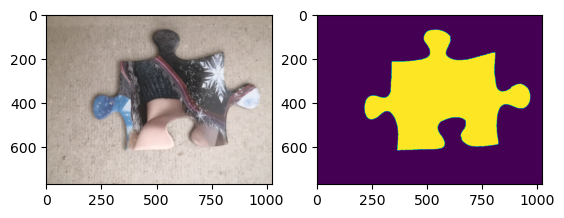

In [18]:
train_dataset = PuzzleDataset(img_dir = "./images-1024x768/train/",
                            mask_dir = "./masks-1024x768/train/")
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
train_loader = DataLoader(train_dataset,batch_size =1, shuffle=True)

# # to visualise the images + masks 
image, mask = train_dataset[2]
image = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
mask = mask.squeeze(0)
# # Display the images
plt.figure()
plt.subplot(1,2,1), plt.imshow(image)
plt.subplot(1,2,2), plt.imshow(mask)



# 3.1 Unet Construction
## Add notes on this here (what is happening)

## Vairant 1 : Using `torch.nn.ConvTranspose2d` for upsampling

In [26]:
# So this is the triple convolution, chat gpt says we should use normalization dont know if we should keep it
class TripleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TripleConv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.triple_conv(x)
    
# the down module is what the unet uses during the first half 
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.conv_pool = nn.Sequential(
            
            TripleConv(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.conv_pool(x)        

# up transpose, 
class UpConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvTranspose, self).__init__()
        # to determine amount of out channels
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = TripleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # adding from the down section
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UpBilinear(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBilinear, self).__init__()
        # the bilinear is provided by the nn module, we set the mode to bilinear here
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = TripleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Padding if necessary to handle odd-sized inputs
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
# this is teh final convolution that is in the unet with a 1x1 kernel
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, variant='convtranspose'):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.variant = variant

        self.inc = TripleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        if variant == 'convtranspose':
            self.up1 = UpConvTranspose(1024, 512)
            self.up2 = UpConvTranspose(512, 256)
            self.up3 = UpConvTranspose(256, 128)
            self.up4 = UpConvTranspose(128, 64)
        elif variant == 'bilinear':
            self.up1 = UpBilinear(1024, 512)
            self.up2 = UpBilinear(512, 256)
            self.up3 = UpBilinear(256, 128)
            self.up4 = UpBilinear(128, 64)
        
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        return logits
    



In [28]:

model = Unet(n_channels=3, n_classes=2, variant='convtranspose')  # Example: 3 input channels, 2 output classes
# Define the loss function
criterion = nn.BCEWithLogitsLoss() 

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for images, masks in train_loader:
        # Move data to the device (GPU/CPU)
        images, masks = images.to(device), masks.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute the loss
        loss = criterion(outputs, masks)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
    
    # Print epoch loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")


writer = SummaryWriter()
writer.add_graph(model, x)
writer.close()


# run tensorboard --logdir=runs to see network

: 

## Vairant 2: Using `torch.nn.Upsample` for bilinear upsampling

# 3.2 Training and evaluation 
### Training
- [ ] Implement the training loop with binary cross entropy loss for pixel-wise classification
- [ ] Adam Optimiser to update the model parameters
**Note** have regularly saved checkpoints and evaluate model in the validation set to avoid over fitting

### Weights and biases integration
Log the following:
- [ ] Track BCE loss over epochs
- [ ] IoU for both training and validation sets to monitor the segmentation performance

### Need to submit from the wandb dashboard
- Loss curves (training and validation over epochs)
- IoU curves (training and validation over epochs)

### Remember to comment on comment on whether the model is overfitting and how to recognise this and deal with the problem

### Evaluation
evaluate model on test set 
- accuracy
- precision
- recall
- F1 score
- IoU

# Select the best model based on the validation IoU and report its performance on the test set

# 4 Other architectures
